# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the CSV files in `data/mimic-iii/final` directory, extracted by the MIMIC-CODE library from the original MIMIC-III v1.4 dataset, in order to be used by our reinforcement learning agent. In particular this notebook will decribe the preprocessing for the **handcrafted state-space** approach as described in [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm

DATA_DIR = '../data/mimic-iii/final/'
INTERVAL_TIME = '4H'

---
## Patient Cohort

Using MIMIC-CODE we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria) along with information regarding the suspected time of infection and 30-day mortality, `hospital_expire_flag`. Let's first import these data;

In [2]:
cohort_df = pd.read_csv(DATA_DIR + 'cohort.csv')
cohort_df['window_start'] = pd.to_datetime(cohort_df['window_start'])
cohort_df['window_end'] = pd.to_datetime(cohort_df['window_end'])

cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


---
Let's see how many ICU stays (i.e. patients) exhibit signs of Sepsis-3

In [3]:
icustay_ids = cohort_df['icustay_id'].values
icustay_ids.size

60

We will collect features in an, as of yet, unpopulated dictionary `data_all`, mapping from each `icustay_id` to the corresponding sequences of vitals, lab results and actions (i.e. maximum vasopressor and IV fluid intake);

In [4]:
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[210989] == {}

---

## Timesteps of 4 Hours

First, for each 72-hour time interval we will precompute all intermediate time steps in increments of 4 hours. Each time we add our output to `data_all`;

In [5]:
# Samples fixed intervals from start to end
def get_intervals(start, end, freq=INTERVAL_TIME):
    return pd.date_range(start=start, end=end, freq=freq).values
    
# Sample daterange from 24h prior to sepsis to 48h after
icustay_timesteps = {x['icustay_id']: get_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [6]:
# Add sampled intervals to `data_all`
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['timesteps'] = timesteps

In [7]:
data_all[210989]['timesteps']

array(['2144-07-10T17:57:00.000000000', '2144-07-10T21:57:00.000000000',
       '2144-07-11T01:57:00.000000000', '2144-07-11T05:57:00.000000000',
       '2144-07-11T09:57:00.000000000', '2144-07-11T13:57:00.000000000',
       '2144-07-11T17:57:00.000000000', '2144-07-11T21:57:00.000000000',
       '2144-07-12T01:57:00.000000000', '2144-07-12T05:57:00.000000000',
       '2144-07-12T09:57:00.000000000', '2144-07-12T13:57:00.000000000',
       '2144-07-12T17:57:00.000000000', '2144-07-12T21:57:00.000000000',
       '2144-07-13T01:57:00.000000000', '2144-07-13T05:57:00.000000000',
       '2144-07-13T09:57:00.000000000', '2144-07-13T13:57:00.000000000',
       '2144-07-13T17:57:00.000000000'], dtype='datetime64[ns]')

---
## Vasopressors

### 1. MetaVision (MV)

**TODO: Process CareVue data**

In [8]:
# MetaVision
vaso_mv_df = pd.read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df['starttime'] = pd.to_datetime(vaso_mv_df['starttime']) # conversion to datetime
vaso_mv_df['endtime'] = pd.to_datetime(vaso_mv_df['endtime'])

vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,norepinephrine,0.502150,41.025643
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,dopamine,0.100121,8.179875
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,norepinephrine,0.200979,16.419956


In [9]:
# Consider ICU stays one-by-one
for icustay_id, treatment_data in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
    
    max_vaso = np.zeros(len(timesteps), dtype=np.float64)
    
    # Which medications were administered in the last 4 hours (window)?
    for i, window_end in enumerate(timesteps):
        window_start = window_end - np.timedelta64(4,'h')
        
        # Inclusion test: treatment time overlaps with current window.
        # NOTE: original R-code erroneously used 'endtime < window_end'
        condition = (treatment_data['starttime'] <= window_end) & (treatment_data['endtime'] > window_start)
        
        # Compute max vaso (norepinephrine-equivalent)
        max_vaso[i] = treatment_data[condition]['mcgkgmin'].max() # (Question: Shouldn't it be sum to be closer to IRL?)
        
    # Set zero if no treatment
    max_vaso = np.nan_to_num(max_vaso, 0)
    
    data_all[icustay_id]['max_vaso'] = max_vaso

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.82it/s]


In [10]:
data_all[239396]['max_vaso']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08002962, 0.12003111, 0.13990203, 0.10297638,
       0.10297638, 0.20046026, 0.2491954 , 0.2491954 , 0.25149818,
       0.25146934, 0.22162817, 0.24435711, 0.24435711])

---
## Fluids

### 1. MetaVision

In [11]:
# Load data
ivfluid_mv_df = pd.read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')
ivfluid_mv_df['starttime'] = pd.to_datetime(ivfluid_mv_df['starttime'])
ivfluid_mv_df['endtime'] = pd.to_datetime(ivfluid_mv_df['endtime'])

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Sanity check: remove amounts outside (0, 5000) range
condition = (ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = (ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]

ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,999.999978,7.766667
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,907.500000,6.050000
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,164.299998,18.250000
5,40124,126179,279554,2130-02-05 11:06:00,2130-02-05 15:06:00,499.999992,4.000000
7,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:21:00,999.999984,8.000000


In [12]:
# Computes how much of each treatment was administered between window_start and window_end
def total_administration_in_window(window_start, window_end, fluid_df):
    dose_start = fluid_df['starttime']
    dose_end = fluid_df['endtime']
    amount = fluid_df['amount']
    duration = fluid_df['duration']
    rate = amount / duration
    
    # Durations of overlaps in hours
    window_duration = (window_end - window_start).astype('timedelta64[s]').astype(int) / 3600
    rear_overlap = (dose_end - window_start).astype('timedelta64[s]').astype(int) / 3600
    front_overlap = (window_end - dose_start).astype('timedelta64[s]').astype(int) / 3600
    
    # Option 1: Dose started before window and ended after window
    c1 = (dose_start < window_start) & (dose_end > window_end)
    total1 = (window_duration * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within window
    c2 = (dose_start < window_start) & (dose_end > window_start) & (dose_end <= window_end)
    total2 = (rear_overlap * rate[c2]).sum()
    
    # Option 3: Dose started and ended in window
    c3 = (dose_start >= window_start) & (dose_start < window_end) & (dose_end <= window_end) & (dose_end > window_start)
    total3 = amount[c3].sum()
    
    # Option 4: Window started before and ended within dose
    c4 = (window_start < dose_start) & (window_end > dose_start) & (window_end < dose_end)
    total4 = (front_overlap * rate[c4]).sum()
            
    return total1 + total2 + total3 + total4
    
    
# Consider ICU stays one-by-one
print('Grab some coffee!')
for icustay_id, treatment_data in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
    
    # To store total fluid intake.
    total_ivfluid = np.zeros(len(timesteps), dtype=np.float64)
    
    # Which fluids were administered in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        window_start = window_end - np.timedelta64(4, 'h')
        
        # Compute total IV fluid
        total_ivfluid[i] = total_administration_in_window(window_start, window_end, treatment_data)
        
    total_ivfluid = np.nan_to_num(total_ivfluid, 0)
        
    # Save!
    data_all[icustay_id]['total_iv_fluid'] = total_ivfluid

Grab some coffee!


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.66it/s]


In [13]:
data_all[239396]['total_iv_fluid']

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    8.55091395, 1225.27569371,
        860.8409346 ,  725.24996289,  820.48022881, 1938.17992514,
       1613.47511671,  992.37863358, 1046.19694227, 1359.03226716,
       1405.51168499, 2085.61893275, 1143.43710779])

---
## Vitals

In [14]:
vitals_df = pd.read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df['window_start'] = pd.to_datetime(vitals_df['window_start'])
vitals_df['window_end'] = pd.to_datetime(vitals_df['window_end'])
vitals_df['intime'] = pd.to_datetime(vitals_df['intime'])
vitals_df['outtime'] = pd.to_datetime(vitals_df['outtime'])
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])

vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000


Which vitals are recorded?;

In [15]:
ALL_VITAL_IDS = list(set(vitals_df['vital_id']))
ALL_VITAL_IDS

['RespRate',
 'MeanBP',
 'SpO2',
 'HeartRate',
 'DiasBP',
 'SysBP',
 'TempC',
 'Glucose']

In [16]:
# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
        
    # Add dict to `data_all` to store aggregated vital measurements
    for vital_id in ALL_VITAL_IDS:
        data_all[icustay_id][vital_id] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (treatment_data['charttime'] > window_start) & (treatment_data['charttime'] < window_end)  
        
        # Compute average value of each vital_id
        vital_averages = treatment_data[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_averages.iteritems():
            data_all[icustay_id][vital_id][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 39.25it/s]


In [17]:
data_all[239396]['MeanBP']

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
       60.333332, 71.      , 70.      , 67.25    , 69.75    , 77.111115,
       61.42857 , 71.28571 , 69.25    , 68.75    , 72.      , 66.      ,
       65.5     ], dtype=float32)

---
## Labs

In [18]:
lab_df = pd.read_csv(DATA_DIR + 'labs_cohort.csv')
lab_df['window_start'] = pd.to_datetime(lab_df['window_start'])
lab_df['window_end'] = pd.to_datetime(lab_df['window_end'])
lab_df['intime'] = pd.to_datetime(lab_df['intime'])
lab_df['outtime'] = pd.to_datetime(lab_df['outtime'])
lab_df['charttime'] = pd.to_datetime(lab_df['charttime'])

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:33:00,LACTATE,4.4
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALAT,9.0
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALBUMIN,3.4
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ANION GAP,20.0
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ASAT,40.0


Which lab measurements were made?;

In [19]:
ALL_LAB_IDS = list(set(lab_df['lab_id'].values))
ALL_LAB_IDS

['PLATELET',
 'BaseExcess',
 'ALBUMIN',
 'BUN',
 'ION_CALCIUM',
 'ANION GAP',
 'WBC',
 'BILIRUBIN',
 'ALAT',
 'LACTATE',
 'CALCIUM',
 'PACO2',
 'CREATININE',
 'CHLORIDE',
 'POTASSIUM',
 'PH',
 'PAO2',
 'MAGNESIUM',
 'PTT',
 'GLUCOSE',
 'HEMOGLOBIN',
 'ASAT',
 'BICARBONATE',
 'PT',
 'SODIUM',
 'BANDS']

In [20]:
# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    for lab_id in ALL_LAB_IDS:
        data_all[icustay_id][lab_id] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (treatment_data['charttime'] > window_start) & (treatment_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        lab_averages = treatment_data[condition].groupby('lab_id')['valuenum'].mean()
        
        for lab_id, value in lab_averages.iteritems():
            data_all[icustay_id][lab_id][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 40.01it/s]


In [21]:
data_all[201006]['ALAT']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 37.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

---
## Urine Output

In [22]:
urine_df = pd.read_csv(DATA_DIR + 'urineoutput_cohort.csv')
urine_df['charttime'] = pd.to_datetime(urine_df['charttime'])

# Drop values exceeding 5000 (just in case)
urine_df = urine_df[(urine_df['value'] > 0) & urine_df['value'] < 5000]

urine_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,10045,126949,203766,2129-11-26 08:00:00,6
1,40310,186361,210989,2144-07-13 06:00:00,10
2,42075,151323,298685,2166-02-13 01:00:00,15
3,10032,140372,267090,2138-04-09 10:00:00,40
4,10044,124073,270154,2152-10-03 11:00:00,200


In [23]:
# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    data_all[icustay_id]['UrineOutput'] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (treatment_data['charttime'] > window_start) & (treatment_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['UrineOutput'][i] = treatment_data[condition]['value'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 69.90it/s]


In [24]:
data_all[279554]['UrineOutput']

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 435., 110., 295.,
       640., 930., 700., 845., 835., 640., 655., 760.], dtype=float32)

---
## FiO2 (Fraction of Inspired Oxygen)

In [25]:
fio2_df = pd.read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df['charttime'] = pd.to_datetime(fio2_df['charttime'])

fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999


In [26]:
# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    data_all[icustay_id]['FiO2'] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (treatment_data['charttime'] > window_start) & (treatment_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['FiO2'][i] = treatment_data[condition]['fio2'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 64.39it/s]


In [27]:
data_all[279554]['FiO2']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40., 35.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

---
## Demographics

In [28]:
features = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [29]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
print(demo_df.columns)

# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]

    N = len(timesteps)
    for feature in features:
        data_all[icustay_id][feature] = np.ones(N) * treatment_data[feature].values[0]

Index(['subject_id', 'hadm_id', 'icustay_id', 'age', 'is_male', 'race_white',
       'race_black', 'race_hispanic', 'race_other', 'height', 'weight', 'vent',
       'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive'],
      dtype='object')


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2865.35it/s]


In [30]:
data_all[279554]['age']

array([66.586, 66.586, 66.586, 66.586, 66.586, 66.586, 66.586, 66.586,
       66.586, 66.586, 66.586, 66.586, 66.586, 66.586, 66.586, 66.586,
       66.586, 66.586, 66.586])

---
# Final Processing

## Add Reward

In [31]:
# Dict mapping from patient to 30-day mortality
mortality_dct = {row['icustay_id']:row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

# Process ICU stays one-by-one
for icustay_id, treatment_data in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
    timesteps = icustay_timesteps[icustay_id]
        
    mortality_30d = mortality_dct[icustay_id]
    
    # Define reward as +15 if survived; -15 otherwise
    rewards = np.zeros(len(timesteps))
    rewards[-1] = -15 if mortality_30d else 15
    
    data_all[icustay_id]['reward'] = rewards

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 29984.30it/s]


In [32]:
print('Patient died?:', bool(mortality_dct[279554]))
data_all[279554]['reward']

Patient died?: False


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 15.])

## Shift Actions in Time by One Timestep

In [40]:
for icustay_id, icustay_data in data_all.items():
    
    # Shift actions and reward sequence forward by one
    if 'total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['total_iv_fluid_shifted'] = list(data_all[icustay_id]['total_iv_fluid'][1:]) + [np.NaN]
        
    if 'max_vaso' in data_all[icustay_id]:
        data_all[icustay_id]['max_vaso_shifted'] = list(data_all[icustay_id]['max_vaso'][1:]) + [np.NaN]
        
    if 'reward' in data_all[icustay_id]:
        data_all[icustay_id]['reward_shifted'] = list(data_all[icustay_id]['reward'][1:]) + [np.NaN]
print('Done!')

Done!


## Convert to DataFrame!

In [34]:
# Convert subdicts to DataFrames
data_all_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data_all.items()}

# Add icustay_id as identifier
for icustay_id in data_all_df.keys():
    data_all_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_all_df = pd.concat(data_all_df.values()).reset_index()

# Casefold column names
data_final_df = pd.DataFrame({'icustay_id': data_all_df['icustay_id'], 
                              'timesteps': data_all_df['timesteps'], 
                              # Discretized action added below
                              'max_vp': data_all_df['max_vaso'],
                              'total_iv': data_all_df['total_iv_fluid'],
                              'max_vp_shifted': data_all_df['max_vaso_shifted'],
                              'total_iv_shifted': data_all_df['total_iv_fluid_shifted'],
                              'reward': data_all_df['reward'],
                              'sirs_score': data_all_df['sirs'],
                              'sofa_score': data_all_df['sofa'],
                              'weight': data_all_df['weight'],
                              'ventilator': data_all_df['vent'],
                              'height': data_all_df['height'],
                              'age': data_all_df['age'],
                              'gender': data_all_df['is_male'],
                              'heartrate': data_all_df['HeartRate'],
                              'temp': data_all_df['TempC'],
                              'mean_bp': data_all_df['MeanBP'],
                              'dias_bp': data_all_df['DiasBP'],
                              'sys_bp': data_all_df['SysBP'],
                              'resp_rate': data_all_df['RespRate'],
                              'spo2': data_all_df['SpO2'],
                              'natrium': data_all_df['SODIUM'],
                              'chloride': data_all_df['CHLORIDE'],
                              'kalium': data_all_df['POTASSIUM'],
                              'trombo': data_all_df['PLATELET'],
                              'leu': data_all_df['WBC'],
                              'anion_gap': data_all_df['ANION GAP'],
                              'aptt': data_all_df['PTT'],
                              'art_ph': data_all_df['PH'],
                              'asat': data_all_df['ASAT'],
                              'alat': data_all_df['ALAT'],
                              'bicarbonaat': data_all_df['BICARBONATE'],
                              'art_be': data_all_df['BaseExcess'],
                              'ion_ca': data_all_df['ION_CALCIUM'],
                              'lactate': data_all_df['LACTATE'],
                              'paco2': data_all_df['PACO2'],
                              'pao2': data_all_df['PAO2'],
                              'shock_index': data_all_df['HeartRate'] / data_all_df['SysBP'],
                              'hb': data_all_df['HEMOGLOBIN'] * 0.6206,
                              'bilirubin': data_all_df['BILIRUBIN'] * (1 / 0.05847953),
                              'creatinine': data_all_df['CREATININE'] * (1 / 0.01131222),
                              'inr': data_all_df['PT'] / 12,
                              'ureum': data_all_df['BUN'] * 0.3571,
                              'albumin': data_all_df['ALBUMIN'] * 10,
                              'magnesium': data_all_df['MAGNESIUM'] * 0.411,
                              'calcium': data_all_df['CALCIUM'] * 0.25,
                              'pf_ratio': data_all_df['PACO2'] / data_all_df['FiO2'],
                              'glucose': data_all_df['Glucose'] * 0.0555})
data_final_df.head(10)

# Don't forget to save
data_final_df.to_csv('data_all_handcrafted.csv')

In [35]:
data_final_df[data_final_df['icustay_id'] == 239396]

,icustay_id,timesteps,max_vp,total_iv,max_vp_shifted,total_iv_shifted,reward,sirs_score,sofa_score,weight,...,hb,bilirubin,creatinine,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose
1102,239396,2123-11-23 14:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1103,239396,2123-11-23 18:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1104,239396,2123-11-23 22:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1105,239396,2123-11-24 02:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1106,239396,2123-11-24 06:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1107,239396,2123-11-24 10:40:00,0.000000,0.000000,0.080030,8.550914,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000
1108,239396,2123-11-24 14:40:00,0.080030,8.550914,0.120031,1225.275694,0.0,3.0,18.0,NaN,...,5.27510,338.579987,335.919922,1.866667,19.640501,29.0,0.9453,1.900,NaN,0.00000
1109,239396,2123-11-24 18:40:00,0.120031,1225.275694,0.139902,860.840935,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,0.129412,0.00000
1110,239396,2123-11-24 22:40:00,0.139902,860.840935,0.102976,725.249963,0.0,3.0,18.0,NaN,...,0.00000,0.000000,380.119934,0.000000,20.354700,0.0,1.0275,2.225,0.169231,5.49450
1111,239396,2123-11-25 02:40:00,0.102976,725.249963,0.102976,820.480229,0.0,3.0,18.0,NaN,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,0.000000,6.43800


## Discretize Action Space

In [36]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals):
    vals = vals[vals > 0]
    return [0] + [np.nanquantile(vals, i) for i in np.linspace(0, 1, 5)]

max_vp_bins = get_quantile_intervals(data_final_df['max_vp_shifted'].values)
tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_shifted'].values)

print('Max. vasopressor bins:', max_vp_bins)
print('Intr. (IV) fluid bins:', tot_iv_bins)

Max. vasopressor bins: [0, 0.0494738031, 0.0799694817035, 0.1601278499, 0.24798583045, 1.413021719475]
Intr. (IV) fluid bins: [0, 2.4201356, 175.0, 489.9999928, 938.33788514, 7224.1500181520005]


In [37]:
# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(data_final_df['max_vp_shifted'], 
                         bins=max_vp_bins, 
                         labels=[0, 1, 2, 3, 4], 
                         include_lowest=True).astype(float)

total_iv_discrete = pd.cut(data_final_df['total_iv_shifted'], 
                           bins=tot_iv_bins, 
                           labels=[0, 1, 2, 3, 4], 
                           include_lowest=True).astype(float)

data_final_df['max_vp_discrete'] = max_vp_discrete
data_final_df['total_iv_discrete'] = total_iv_discrete
data_final_df['discretized_action'] = 5 * total_iv_discrete + max_vp_discrete

In [38]:
data_final_df[data_final_df['icustay_id'] == 239396]

,icustay_id,timesteps,max_vp,total_iv,max_vp_shifted,total_iv_shifted,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,max_vp_discrete,total_iv_discrete,discretized_action
1102,239396,2123-11-23 14:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,0.0,0.0,0.0
1103,239396,2123-11-23 18:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,0.0,0.0,0.0
1104,239396,2123-11-23 22:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,0.0,0.0,0.0
1105,239396,2123-11-24 02:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,0.0,0.0,0.0
1106,239396,2123-11-24 06:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,0.0,0.0,0.0
1107,239396,2123-11-24 10:40:00,0.000000,0.000000,0.080030,8.550914,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.00000,2.0,1.0,7.0
1108,239396,2123-11-24 14:40:00,0.080030,8.550914,0.120031,1225.275694,0.0,3.0,18.0,NaN,...,1.866667,19.640501,29.0,0.9453,1.900,NaN,0.00000,2.0,4.0,22.0
1109,239396,2123-11-24 18:40:00,0.120031,1225.275694,0.139902,860.840935,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,0.129412,0.00000,2.0,3.0,17.0
1110,239396,2123-11-24 22:40:00,0.139902,860.840935,0.102976,725.249963,0.0,3.0,18.0,NaN,...,0.000000,20.354700,0.0,1.0275,2.225,0.169231,5.49450,2.0,3.0,17.0
1111,239396,2123-11-25 02:40:00,0.102976,725.249963,0.102976,820.480229,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,0.000000,6.43800,2.0,3.0,17.0


---

## Done! Let's Visualize!

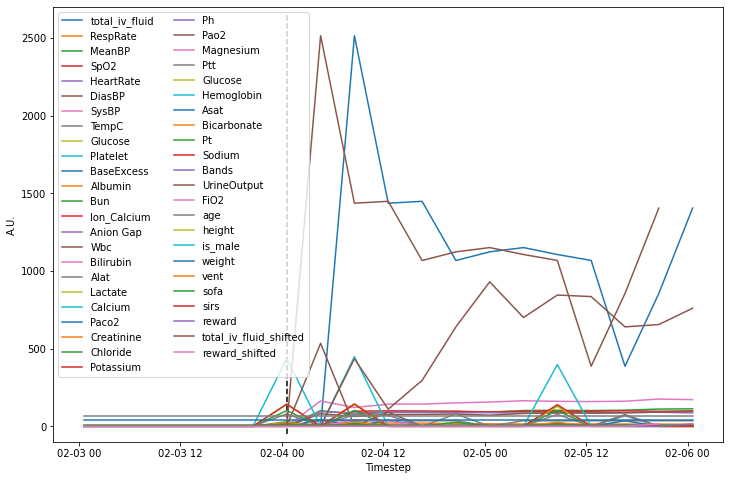

In [39]:
import matplotlib.pyplot as plt

data = data_all[279554] # Without MaxVaso/TotalFluid offset!

x = data['timesteps']

plt.figure(figsize=(12, 8))

# Suspected time of infection
plt.plot([x[6], x[6]], [-50, 2650], color='k', linestyle='--')

# Plots data
for key, y in data.items():
    if key != 'timesteps':
        plt.plot(x, y, label=key.title() if key.isupper() else key)

plt.ylim(-100, 2700)
plt.xlabel('Timestep')
plt.ylabel('A.U.')
plt.legend(ncol=2)
plt.show()